# Processing and interacting with NASA's Visible Infrared Imaging Radiometer Suite (VIIRS) data products

The Land Processes Distributed Active Archive Center (LP DAAC) has begun distributing four NASA Visible Infrared Imaging Radiometer Suite (VIIRS) Surface Reflectance products. This tutorial demonstrates how to open and interact with VIIRS Surface Reflectance data files. Additionally this tutorial demonstrates how to define the coordinate reference system (CRS) and export each science dataset layer as a GeoTIFF file that can be loaded with spatial referencing into a GIS and/or Remote Sensing software program. Information about the four NASA VIIRS Surface Reflectance products can be found using the links below.

* __VNP09A1__ - VIIRS/NPP Surface Reflectance 8-Day L3 Global 1km SIN Grid
    *  http://dx.doi.org/10.5067/VIIRS/VNP09A1.001
* __VNP09GA__ - VIIRS/NPP Surface Reflectance Daily L2G Global 1km and 500m SIN Grid
    * http://dx.doi.org/10.5067/VIIRS/VNP09GA.001
* __VNP09H1__ - VIIRS/NPP Surface Reflectance 8-Day L3 Global 500m SIN Grid
    * http://dx.doi.org/10.5067/VIIRS/VNP09H1.001
* __VNP09CMG__ - VIIRS/NPP Surface Reflectance Daily L3 Global 0.05 Deg CMG
    * http://dx.doi.org/10.5067/VIIRS/VNP09CMG.001

The NASA VIIRS Surface Reflectance products are archived and distributed in a file format call HDF-EOS5. The Hierarchical Data Format version 5 (HDF5) is a NASA selected format of choice for standard science product archival and distribution, and is the underlying format for HDF-EOS5. HDF-EOS is the standard format and I/O library for the Earth Observing System (EOS) Data and Information System (EOSDIS). HDF-EOS5 extends the capabilities of the HDF5 storage format, adding support for the various EOS data types (e.g., Point, Swath, and Grid) into the HDF5 framework. This tutorial demonstrates how to add and interact with VIIRS HDF-EOS5 (.h5) data in a python work enviroment.  

To use this tutorial, __start__ by downloading VIIRS Surface Reflectance data from the LP DAAC Data Pool or NASA Earthdata Search. Change the __inDir__ variable below to the path to the directory where your data is stored (e.g., C:/Data/VIIRS/VNP09A1) and begin working through each line in the notebook.

This tutorial was specifically developed for NASA VIIRS Surface Reflectance HDF-EOS5 files and should only be used for the data products outlined above.

### Data

VIIRS datasets can be downloaded directly from the LP DAAC Data Pool (https://e4ftl01.cr.usgs.gov/VIIRS/). This tutorial uses a dataset from the VNP09A1 product on March 13th, 2012 for tile h10v06 (https://e4ftl01.cr.usgs.gov/VIIRS/VNP09A1.001/2012.03.13/VNP09A1.A2012073.h10v06.001.2016297035634.h5).

---

In [1]:
%autosave 0

Autosave disabled


### Import the python modules you'll need to interact with the HDF-EOS5 (.h5) file and data within

In [2]:
import h5py
import numpy as np
from osgeo import gdal, gdal_array
import os

### Identify the VIIRS .h5 file to process and interact with.

#### In this example, we are describing a situation where a series of VIIRS .h5 files have been downloaded to a single folder in a directory. The following will find all of the .h5 files is an input directory and create a python list of all the file names.

In [3]:
inDir = '/media/denis/seagate/BRASIL/VIIRS/VNP09H1'  

In [5]:
fileList = [file for file in os.listdir(inDir) if file.endswith('.h5')]
for f in fileList:
    print(f)

VNP09H1.A2013241.h13v11.001.2016363043202.h5
VNP09H1.A2013249.h13v11.001.2016363181900.h5
VNP09H1.A2013257.h13v11.001.2016364125805.h5
VNP09H1.A2013265.h13v11.001.2016365094121.h5
VNP09H1.A2013273.h13v11.001.2016366113101.h5
VNP09H1.A2013281.h13v11.001.2017001144523.h5
VNP09H1.A2013289.h13v11.001.2017002071004.h5
VNP09H1.A2013297.h13v11.001.2017003022613.h5
VNP09H1.A2013305.h13v11.001.2017003210519.h5
VNP09H1.A2013313.h13v11.001.2017005020303.h5
VNP09H1.A2013329.h13v11.001.2017007095934.h5
VNP09H1.A2013337.h13v11.001.2017008215907.h5
VNP09H1.A2013345.h13v11.001.2017008204803.h5
VNP09H1.A2013353.h13v11.001.2017009121243.h5
VNP09H1.A2013361.h13v11.001.2017010214650.h5
VNP09H1.A2014001.h13v11.001.2017011101539.h5
VNP09H1.A2014009.h13v11.001.2017012085012.h5
VNP09H1.A2014017.h13v11.001.2017013014641.h5
VNP09H1.A2014025.h13v11.001.2017015165216.h5
VNP09H1.A2014033.h13v11.001.2017017015050.h5
VNP09H1.A2014041.h13v11.001.2017015231349.h5
VNP09H1.A2014057.h13v11.001.2017017191023.h5
VNP09H1.A2

#### Select a file from the list to process and interact with.

In [6]:
inFile = fileList[0]    # NOTE: fileList[0] selects the 1st file in the list

inFile

'VNP09H1.A2013241.h13v11.001.2016363043202.h5'

In [7]:
inFileLoc = '{}/{}'.format(inDir, inFile)

#### At the end of this tutorial we will be creating a series of GeoTIFFs that will be saved to a specified output location. Now lets create an output directory within the specified input directory (inDir).

In [8]:
outDir = '{}/output'.format('/'.join(inFileLoc.split('/')[:-1]))
if not os.path.exists(outDir):
    os.makedirs(outDir)

outDir

'/media/denis/seagate/BRASIL/VIIRS/VNP09H1/output'

#### VIIRS climate model grids (CMG) are mapped to a different coordinate reference system than the other VIIRS level 3 products. The VIIRS CMG datasets are referenced to the Geographic coordinate space, while the other VIIRS level 3 products are referenced to a projected Sinusoidal coordinate system identical to the one used for the Moderate Resolution Imaging Spectroradiometer (MODIS) collection.

In [9]:
projInfo = {'SINU':'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid", DATUM["Not specified (based on custom spheroid)", SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0], UNIT["degree",0.0174532925199433]], PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]',
            'GEO':'GEOGCS["Unknown datum based upon the Clarke 1866 ellipsoid", DATUM["Not specified (based on Clarke 1866 spheroid)", SPHEROID["Clarke 1866",6378206.4,294.9786982139006]], PRIMEM["Greenwich",0], UNIT["degree",0.0174532925199433]]'}

### Read in a VIIRS HDF-EOS5 file.

#### Read in the _inFileLoc_ python object that we created above.

In [10]:
f = h5py.File('{}'.format(inFileLoc))

#### Specify the file name for the output GeoTIFFs that will be generated later

In [11]:
fileName = f.filename.split('/')[-1][:-3]

fileName

'VNP09H1.A2013241.h13v11.001.2016363043202'

### Navigate the HDF-EOS5 file

#### The VIIRS HDF-EOS5 file contains two groups in which data and metadata is stored.

In [12]:
list(f)

['HDFEOS', 'HDFEOS INFORMATION']

#### The _HDFEOS_ group is where you access the VIIRS data. 

In [13]:
list(f['HDFEOS'])

['ADDITIONAL', 'GRIDS']

#### The _HDFEOS INFORMATION_ group contains the metadata for the file. The _StructMetadata.0_ object within stores the metadata information.

In [14]:
list(f['HDFEOS INFORMATION'])

['StructMetadata.0']

#### All of the objects in the VIIRS HDF-EOS5 file can be identified using the following commands...

In [15]:
all_h5_objs = []
f.visit(all_h5_objs.append)

all_h5_objs

['HDFEOS',
 'HDFEOS/ADDITIONAL',
 'HDFEOS/ADDITIONAL/FILE_ATTRIBUTES',
 'HDFEOS/GRIDS',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_I1',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_I2',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_I3',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_QC_500m',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_State_500m',
 'HDFEOS INFORMATION',
 'HDFEOS INFORMATION/StructMetadata.0']

#### Get the geoinformation from the _StructMetadata.0_ object within the HDF-EOS5 file.

In [16]:
f_metadata = f['HDFEOS INFORMATION']['StructMetadata.0'].value.split()
f_metadata_byte2str = [s.decode('utf-8') for s in f_metadata]

f_metadata_byte2str

['GROUP=SwathStructure',
 'END_GROUP=SwathStructure',
 'GROUP=GridStructure',
 'GROUP=GRID_1',
 'GridName="VNP_Grid_500m_L3_2d"',
 'XDim=2400',
 'YDim=2400',
 'UpperLeftPointMtrs=(-5559752.598333,-2223901.039333)',
 'LowerRightMtrs=(-4447802.078667,-3335851.559000)',
 'Projection=HE5_GCTP_SNSOID',
 'ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)',
 'SphereCode=-1',
 'GROUP=Dimension',
 'END_GROUP=Dimension',
 'GROUP=DataField',
 'OBJECT=DataField_1',
 'DataFieldName="SurfReflect_I1"',
 'DataType=H5T_NATIVE_SHORT',
 'DimList=("YDim","XDim")',
 'MaxdimList=("YDim","XDim")',
 'END_OBJECT=DataField_1',
 'OBJECT=DataField_2',
 'DataFieldName="SurfReflect_I2"',
 'DataType=H5T_NATIVE_SHORT',
 'DimList=("YDim","XDim")',
 'MaxdimList=("YDim","XDim")',
 'END_OBJECT=DataField_2',
 'OBJECT=DataField_3',
 'DataFieldName="SurfReflect_I3"',
 'DataType=H5T_NATIVE_SHORT',
 'DimList=("YDim","XDim")',
 'MaxdimList=("YDim","XDim")',
 'END_OBJECT=DataField_3',
 'OBJECT=DataField_4',
 'DataFieldName="S

#### Identify the upper-left longitude and latidute coordinates from the metadata

In [17]:
ulc = [i for i in f_metadata_byte2str if 'UpperLeftPointMtrs' in i]
ulcLon = float(ulc[0].replace('=', ',').replace('(', '').replace(')', '').split(',')[1])
ulcLat = float(ulc[0].replace('=', ',').replace('(', '').replace(')', '').split(',')[2])

#### Extract the _GridName_ element from the metadata. This will be used to determine if the file we're working with is a CMG or one of the other VIIRS level 3 products.

In [18]:
gridName = [i.split('=')[1].replace('\"', '') for i in f_metadata_byte2str if 'GridName=' in i]

gridName

['VNP_Grid_500m_L3_2d']

#### Assign the projection parameters based on the _gridName_ python object

In [19]:
if gridName == 'VNP_CMG':
    prj = projInfo['GEO']
else:
    prj = projInfo['SINU']

### Identify the science datasets (SDS) in the HDF-EOS5 file

#### Generate a list of all the SDS layers

In [20]:
#all_h5_objs = []
#f.visit(all_h5_objs.append)
    #all_groups   = [obj for obj in all_h5_objs if isinstance(f[obj],h5py.Group)]
all_datasets = [obj for grid in gridName for obj in all_h5_objs if isinstance(f[obj],h5py.Dataset) and grid in obj]

all_datasets

['HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_I1',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_I2',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_I3',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_QC_500m',
 'HDFEOS/GRIDS/VNP_Grid_500m_L3_2d/Data Fields/SurfReflect_State_500m']

### Visualize and Process VIIRS SDS - VNP09A1 Example'

#### Use matplotlib to plot images using VIIRS' SurfReflect_M5 (R), SurfReflect_M4 (G), SurfReflect_M3 (B), and SurfReflect_M7 (NIR) layers

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Extract the red (SurfReflect_M5), green (SurfReflect_M4), and blue (SurfReflect_M3) SDS layers from the HDF-EOS5 file

In [23]:
rObj = f['{}'.format(all_datasets[2])]
gObj = f['{}'.format(all_datasets[1])]
bObj = f['{}'.format(all_datasets[0])]

#### List the attributes for the _rObj_ and extract scale factor and fill value

In [24]:
list(rObj.attrs)

['_FillValue',
 'long_name',
 'units',
 'valid_range',
 'scale_factor',
 'scale_factor_err',
 'add_offset',
 'add_offset_err',
 'calibrated_nt']

In [25]:
scaleFactor = rObj.attrs['scale_factor'][0]
fillValue = rObj.attrs['_FillValue'][0]

#### Extract the data for each SDS and apply the scale factor

In [26]:
rArr = rObj.value * scaleFactor
gArr = gObj.value * scaleFactor
bArr = bObj.value * scaleFactor
# Create and array stack (rgb)
rgbArray = np.dstack((rArr,gArr,bArr))

#### Specify the fill values

In [27]:
rgbArray[rgbArray == fillValue * scaleFactor] = np.nan

#### Visualize the RGB image

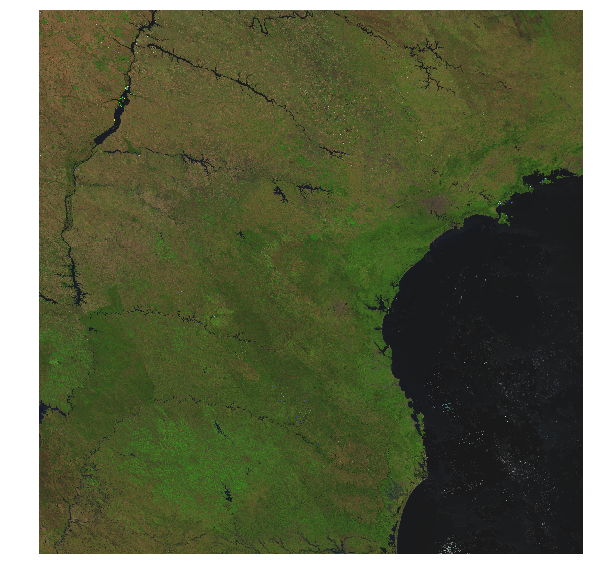

In [28]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(rgbArray, interpolation='nearest', alpha=0.90)

#### Calculate the normalized difference vegetation index (NDVI) using the NIR (SurfReflect_M7) and red (SurfReflect_M5) layers

In [33]:
nirArr = f['{}'.format(all_datasets[1])].value * scaleFactor
nirArr[nirArr == fillValue * scaleFactor] = np.nan
# Specify fill value for the red band
rArr[rArr == fillValue * scaleFactor] = np.nan

In [38]:
ndvi = (nirArr - rArr) / (nirArr + rArr)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


#### Visualize the NDVI array

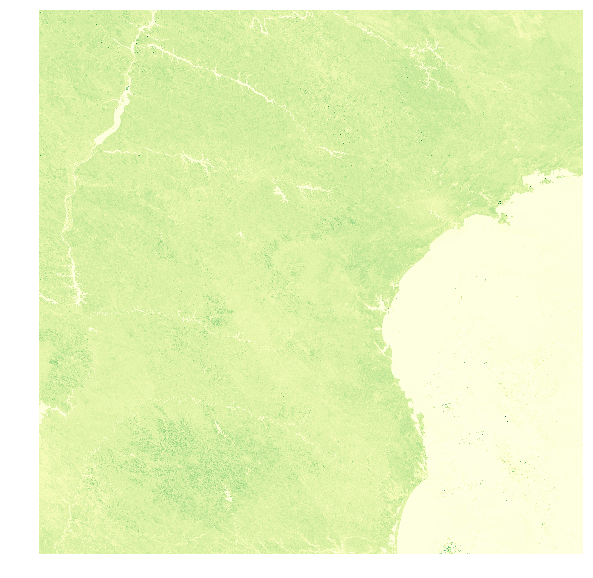

In [41]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(nirArr, cmap = 'YlGn')

#### Compute histogram to better stretch the contrast of the image

ValueError: range parameter must be finite.

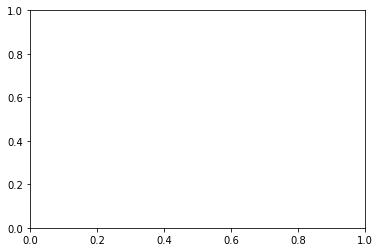

In [46]:
plt.hist(ndvi, bins=50);
plt.xticks(np.arange(-1.0, 1.25, 0.25));

**Note:** The semi-colon at the end suppresses output array that prints with the histogram

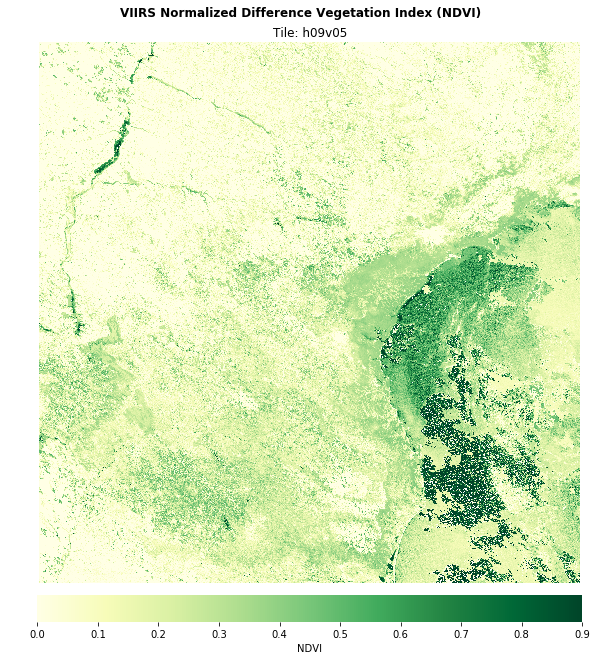

In [47]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('VIIRS Normalized Difference Vegetation Index (NDVI)', fontsize=12, fontweight='bold')
plt.axis('off')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.93)
ax.set_title('Tile: h09v05')
ax1 = plt.gca()
im = ax1.imshow(ndvi, vmin = 0, vmax = 0.9, cmap = 'YlGn')
plt.colorbar(im, orientation='horizontal', fraction=0.047, pad=0.02, label = 'NDVI').outline.set_visible(False)
plt.show()
#fig.savefig('{}_ndvi.png'.format(inDir))

### Create GeoTIFF outputs

#### Loop through each SDS in the VIIRS HDF-EOS5 file. Create a georeferenced GeoTIFF for each SDS.

In [49]:
for ds in all_datasets:
    dsName = ds.split('/')[-1]
    print('Processing: {}'.format(dsName))
    dsArray = f[ds].value
    nRow = dsArray.shape[0]
    nCol = dsArray.shape[1]
    '''Currently, VIIRS HDF-EOS5 files do not contain information regarding the spatial resolution of the dataset within.'''
    if nRow == 1200:   # VIIRS A1 - 1km or 1000m
        yRes = -926.6254330555555    
        xRes = 926.6254330555555
    elif nRow == 2400:  #  VIIRS H1 - 500m
        yRes = -463.31271652777775
        xRes = 463.31271652777775
    elif nRow == 3600 and nCol == 7200:  #  VIIRS CMG
        yRes = -0.05
        xRes = 0.05
        # Re-set upper left dims for CMG product                
        ulcLon = -180.00
        ulcLat = 90.00
    geoInfo = (ulcLon, xRes, 0, ulcLat, 0, yRes)
    
    dataType = gdal_array.NumericTypeCodeToGDALTypeCode(dsArray.dtype)
    format = "GTiff"
    driver = gdal.GetDriverByName(format)
    print('Creating {}_{}.tif'.format(fileName, dsName))
    out_ds = driver.Create('{}/{}_{}.tif'.format(outDir, fileName, dsName), nCol, nRow, 1, dataType)
    out_ds.GetRasterBand(1).WriteArray(dsArray)
    out_ds.SetGeoTransform(geoInfo)
    '''The projection parameters were specified and assigned earlier in the tutorial. See proj object.'''
    out_ds.SetProjection(prj)
    out_ds = None
    print('Output location: {}/{}_{}.tif'.format(outDir,fileName, dsName))
    

Processing: SurfReflect_I1
Creating VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_I1.tif
Output location: /media/denis/seagate/BRASIL/VIIRS/VNP09H1/output/VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_I1.tif
Processing: SurfReflect_I2
Creating VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_I2.tif
Output location: /media/denis/seagate/BRASIL/VIIRS/VNP09H1/output/VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_I2.tif
Processing: SurfReflect_I3
Creating VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_I3.tif
Output location: /media/denis/seagate/BRASIL/VIIRS/VNP09H1/output/VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_I3.tif
Processing: SurfReflect_QC_500m
Creating VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_QC_500m.tif
Output location: /media/denis/seagate/BRASIL/VIIRS/VNP09H1/output/VNP09H1.A2013241.h13v11.001.2016363043202_SurfReflect_QC_500m.tif
Processing: SurfReflect_State_500m
Creating VNP09H1.A2013241.h13v11.001.2016363043202_Sur